<a href="https://colab.research.google.com/github/gouthamans14/Transformers_Notebooks/blob/main/Seq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
! pip install sacrebleu bert-score

In [14]:
!pip install transformers datasets

#Both are for tokenizers



In [15]:
! pip install sacremoses


In [16]:
! pip install sentencepiece

In [17]:
from datasets import load_dataset

## Load Dataset

In [18]:

data = load_dataset("kde4", lang1="en", lang2="fr")

In [19]:
data

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 210173
    })
})

In [20]:
### Selecting 1000 random samples
small = data["train"].shuffle(seed=42).select(range(1_000))

In [21]:
split = small.train_test_split(seed=42)

In [22]:
split["train"][1]

{'id': '47571', 'translation': {'en': 'KDE', 'fr': 'KDE'}}

### Our dataset contains 2 columns:

* ID - of no use
* Transalation

### How to Preprocess the Data

* We need to use 2 seperate tokenizer: Both yes & No
* Yes, Since there must e seperate tokenizer for each language
* No, Because they are both stored in the same tokenizer in the hugging face liabrary

In [23]:
from transformers import AutoTokenizer

checkpoint = "Helsinki-NLP/opus-mt-en-fr"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [24]:
# Both are for tokenizers
# ! pip install sacremoses

# ! pip install sentencepiece

In [25]:
en = split['train'][5]['translation']['en']
fr = split['test'][5]['translation']['fr']
en,fr

('You can either pick a file or enter its name in the Location: box.',
 "Extenseur & #160;: argument incorrect à « & #160; Nombre & #160; » & #160;: %1 n'est pas un spécificateur d'élément valable")

#### To tokenize the input

In [26]:
split

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 750
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 250
    })
})

In [27]:
inputs = tokenizer(en)

In [28]:
en

'You can either pick a file or enter its name in the Location: box.'

In [29]:
inputs

{'input_ids': [213, 115, 1828, 8437, 15, 1437, 57, 3307, 96, 1129, 18, 4, 4577, 37, 5311, 3, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

#### To tokenize the target we need to use something called THE CONTEXT MANAGER

In [30]:
### Old method:
# with tokenizer.as_target_tokenizer():
#     targets = tokenizer(fr)

### New method:
targets = tokenizer(text_target=fr)

In [31]:
targets

{'input_ids': [3453, 6867, 1547, 402, 38492, 7735, 20556, 17, 153, 402, 29033, 4322, 402, 29033, 416, 402, 38492, 301, 548, 81, 6, 82, 53, 34, 7608, 12319, 18458, 20, 6, 12039, 12679, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [32]:
tokenizer.convert_ids_to_tokens(inputs['input_ids'])

['▁You',
 '▁can',
 '▁either',
 '▁pick',
 '▁a',
 '▁file',
 '▁or',
 '▁enter',
 '▁its',
 '▁name',
 '▁in',
 '▁the',
 '▁Location',
 ':',
 '▁box',
 '.',
 '</s>']

#### Note:
* No CLS and SEP tokens(this is for BERT)
* we have tokens which ends with </s>
* No ## for subsequent subwords, each new word starts with _ and subsequent subwords have no prefix

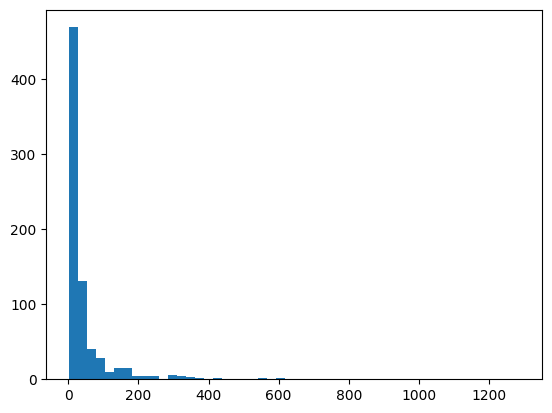

In [33]:

import matplotlib.pyplot as plt

train = split['train']['translation']
input_lens = [len(tr['en']) for tr in train]

plt.hist(input_lens, bins=50);

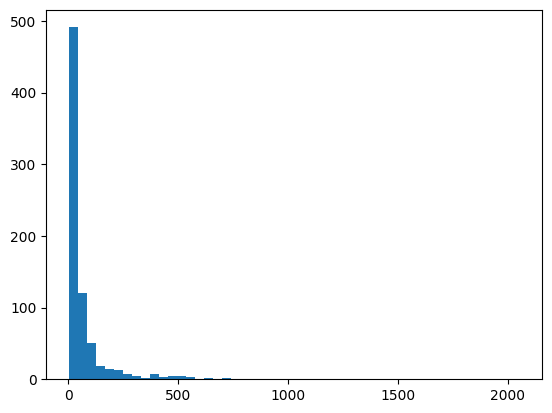

In [34]:
target_lens = [len(tr['fr']) for tr in train]
plt.hist(target_lens, bins=50);

### Tokenization

* Inputs and Targets will be of different length

In [35]:
max_input_len = 128
max_target_len = 128
def tokenized_fn(batch):
    inputs =[x['en'] for x in batch['translation']]
    targets = [x['fr'] for x in batch['translation']]

    tokenized_inputs = tokenizer(
        inputs, max_length = max_input_len, truncation=True
    )

    tokenized_targets = tokenizer(text_target=targets,
                                  max_length = max_target_len,
                                  truncation=True)

    tokenized_inputs['labels'] = tokenized_targets['input_ids']

    return tokenized_inputs

In [36]:
split

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 750
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 250
    })
})

In [37]:
tokenized_datasets = split.map(
    tokenized_fn,
    batched=True,
    remove_columns=split['train'].column_names,

)

### Modelling

* Translation is a "Sequence to Sequence" task.
* Seq2Seq = Encoder + Decoder
* Decoder = Language Model(LM)
* Similar to generating text, except instead of completely random sentences,
conditioned on encoder output.(Vector representation of input sentence, Context vector)



In [38]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

### Data Collator

* New Datacollator for seq2seq.
* We usually do all our data preprocessing before creating the model.But, here we are actually going to pass the model into datacollator.


In [39]:
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

* The model is passed because we need to populate decoder input IDs

Need for a Data Collator:
* Data collator does the Padding (per batch) and convert data to torch tensors
* Additionaly here, as decoder itself is a NN, Decoder have input from Encoder(Context Vector) and inputs(shifted targets) predicted first output is fed as input to next decodet unit.
* Decoder input ids are shifted version of the targets.



#### Checking Data Collator

In [40]:
[tokenized_datasets['train'][i] for i in range(1,3)]

[{'input_ids': [526, 3261, 0],
  'attention_mask': [1, 1, 1],
  'labels': [526, 3261, 0]},
 {'input_ids': [3492,
   3070,
   6443,
   37,
   443,
   61,
   32,
   317,
   2203,
   4824,
   514,
   1807,
   971,
   4,
   4124,
   3,
   0],
  'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  'labels': [34023,
   5,
   3948,
   5,
   372,
   402,
   38492,
   350,
   823,
   95,
   13439,
   2,
   25985,
   14,
   6,
   3996,
   3,
   0]}]

In [41]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(0,2)])

In [42]:
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

* We have one extra column called decoder_input_ids

In [43]:
tokenized_datasets["train"][:2]["labels"]

[[402, 9950, 108, 2240, 14, 6, 38367, 13218, 0], [526, 3261, 0]]

In [44]:
batch["labels"]

tensor([[  402,  9950,   108,  2240,    14,     6, 38367, 13218,     0],
        [  526,  3261,     0,  -100,  -100,  -100,  -100,  -100,  -100]])

In [45]:
batch["decoder_input_ids"]

tensor([[59513,   402,  9950,   108,  2240,    14,     6, 38367, 13218],
        [59513,   526,  3261,     0, 59513, 59513, 59513, 59513, 59513]])

In [46]:
split['train'][25]['translation']

{'en': 'Netscape Communicator reg; plugins (for viewing Flash reg;, Real reg; Audio, Real reg; Video, etc.)',
 'fr': 'Netscape Communicator reg; modules externes (pour afficher Flash reg;, Real reg; Audio, Real reg; Video, etc.)'}

In [47]:
split

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 750
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 250
    })
})

### Decoder input id are shifted version of Targets

In [48]:
tokenizer.convert_ids_to_tokens(batch['labels'][1])

['▁K', 'DE', '</s>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']

In [49]:
tokenizer.convert_ids_to_tokens(batch['decoder_input_ids'][1])

['<pad>', '▁K', 'DE', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

## Evaluation

Why we need different metrics for transalation task?

* Different sentences can mean the same thing. ie one sentences be transalated in different ways
* More than one valid translation
* BLEU score looks at n-grams (subsequences of size n)
* Best Score over each reference is chosen

In [50]:
from datasets import load_metric

bleu_metric = load_metric("sacrebleu")
bert_metric = load_metric("bertscore")

<ipython-input-50-ec0ba0363219>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu")


In [51]:
bleu_metric.compute(predictions=["I love cats"], references=[['I love cats']])

{'score': 0.0,
 'counts': [3, 2, 1, 0],
 'totals': [3, 2, 1, 0],
 'precisions': [100.0, 100.0, 100.0, 0.0],
 'bp': 1.0,
 'sys_len': 3,
 'ref_len': 3}

* Score is 0 because it does not work with short sentences

In [52]:
s ="Marian is an effecient NMT framework written in pure C++"

In [53]:
bleu_metric.compute(predictions=[s], references=[[s]])

{'score': 100.00000000000004,
 'counts': [12, 11, 10, 9],
 'totals': [12, 11, 10, 9],
 'precisions': [100.0, 100.0, 100.0, 100.0],
 'bp': 1.0,
 'sys_len': 12,
 'ref_len': 12}

* Score is 100 instead of 1

* Bleu score compares n grams?

In [54]:
bert_metric.compute(
    predictions=['I love cats'], references=[["I like cats","I hate cats"]], lang="en"
)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'precision': [0.9803369641304016],
 'recall': [0.9803369641304016],
 'f1': [0.9803369641304016],
 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.31.0)'}

In [55]:
import numpy as np

In [109]:
def compute_metrics(preds_and_labels):
    preds,labels = preds_and_labels
    decoded_preds = tokenizer.batch_decode(preds,skip_special_tokens=True)
    labels = np.where(labels!=-100, labels,tokenizer.pad_token_id)
    decoded_labels =tokenizer.batch_decode(labels,skip_special_tokens=True)
    #print(decoded_labels)

    decoder_preds =[preds.strip() for preds in decoded_preds]
    decoder_labels= [[label.strip()] for label in decoded_labels]
    #print(decoder_preds)
    #print(decoder_labels)
    bleu = bleu_metric.compute(
        predictions = decoder_preds,
        references = decoder_labels
    )
    bert = bert_metric.compute(
        predictions = decoder_preds,
        references = decoder_labels,
        lang="fr"
    )

    return {'bleu': bleu,
            'bert': np.mean(bert['f1']) }

In [110]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    "finetuned-Model",
    evaluation_strategy ="no",# Its time consuming so setting up no
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_eval_batch_size=64,
    per_device_train_batch_size=32,
    weight_decay = 0.01,
    num_train_epochs=3,
    predict_with_generate=True,
    #During Evaluation, generate predictions without knowing true targets
    #fed into devoder
    fp16 = True, #We use 32 bits to store floating point numbers,
    ## So all the weights take up half as much space(normally 32-bit). Even with this, you might run out of GPU ram.
)

In [111]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
  "my_finetuned_model",
  evaluation_strategy="no",
  save_strategy="epoch",
  learning_rate=2e-5,
  per_device_train_batch_size=32,
  per_device_eval_batch_size=64,
  weight_decay=0.01,
  save_total_limit=3,
  num_train_epochs=3,
  predict_with_generate=True,
  fp16=True,
)

In [112]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 750
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 250
    })
})

In [113]:
from transformers import Seq2SeqTrainingArguments


In [114]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [115]:
trainer.evaluate(max_length=max_target_len)

Trainer is attempting to log a value of "{'score': 44.15272948398562, 'counts': [1864, 1270, 916, 686], 'totals': [2637, 2387, 2187, 2012], 'precisions': [70.68638604474782, 53.20485965647256, 41.88385916780979, 34.09542743538768], 'bp': 0.9171705028533759, 'sys_len': 2637, 'ref_len': 2865}" of type <class 'dict'> for key "eval/bleu" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 1.3957126140594482,
 'eval_bleu': {'score': 44.15272948398562,
  'counts': [1864, 1270, 916, 686],
  'totals': [2637, 2387, 2187, 2012],
  'precisions': [70.68638604474782,
   53.20485965647256,
   41.88385916780979,
   34.09542743538768],
  'bp': 0.9171705028533759,
  'sys_len': 2637,
  'ref_len': 2865},
 'eval_bert': 0.8793061528205871,
 'eval_runtime': 24.6059,
 'eval_samples_per_second': 10.16,
 'eval_steps_per_second': 0.163}

In [116]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss


TrainOutput(global_step=72, training_loss=1.2333659066094294, metrics={'train_runtime': 31.9392, 'train_samples_per_second': 70.446, 'train_steps_per_second': 2.254, 'total_flos': 52772338925568.0, 'train_loss': 1.2333659066094294, 'epoch': 3.0})

In [117]:
trainer.evaluate(max_length=max_target_len)

Trainer is attempting to log a value of "{'score': 43.440511317697556, 'counts': [1859, 1259, 903, 671], 'totals': [2775, 2525, 2324, 2148], 'precisions': [66.990990990991, 49.86138613861386, 38.855421686746986, 31.238361266294227], 'bp': 0.9680878589633352, 'sys_len': 2775, 'ref_len': 2865}" of type <class 'dict'> for key "eval/bleu" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 1.3405768871307373,
 'eval_bleu': {'score': 43.440511317697556,
  'counts': [1859, 1259, 903, 671],
  'totals': [2775, 2525, 2324, 2148],
  'precisions': [66.990990990991,
   49.86138613861386,
   38.855421686746986,
   31.238361266294227],
  'bp': 0.9680878589633352,
  'sys_len': 2775,
  'ref_len': 2865},
 'eval_bert': 0.872798297047615,
 'eval_runtime': 24.4755,
 'eval_samples_per_second': 10.214,
 'eval_steps_per_second': 0.163,
 'epoch': 3.0}

In [122]:
from transformers import pipeline
translator = pipeline("translation", model= "/content/finetuned-model/checkpoint-24", device=0)

In [126]:
translator("I hope this course has helped you on your data science journey!")

[{'translation_text': "J'espère que ce cours vous a aidé dans votre parcours data science!"}]

In [127]:
translator.evaluate(max_length=max_target_len)

AttributeError: ignored